In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow_probability as tfp

2023-10-26 17:18:10.430420: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('./fraud.csv')

In [4]:
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

In [6]:
df.drop(['step'], axis=1, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   type            object 
 1   amount          float64
 2   oldbalanceOrg   float64
 3   newbalanceOrig  float64
 4   oldbalanceDest  float64
 5   newbalanceDest  float64
 6   isFraud         int64  
 7   isFlaggedFraud  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 388.3+ MB


# Feature Engineering

### 1. Log Transformation

In [8]:
df['Log_Transaction_Amount'] = np.log1p(df['amount'])

## 2. Transaction Amount Difference

In [9]:
df['Transaction_Amount_Difference'] = df['newbalanceOrig'] - df['oldbalanceOrg']

## Balance Difference

In [10]:
df['Origin_Account_Balance_Difference'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['Destination_Account_Balance_Difference'] = df['newbalanceDest'] - df['oldbalanceDest']

In [11]:
df['Origin_Account_Balance_Ratio'] = df['oldbalanceOrg'] / df['newbalanceOrig']
df['Destination_Account_Balance_Ratio'] = df['oldbalanceDest'] / df['newbalanceDest']

In [12]:
df['Transaction_Amount_to_Balance_Difference_Ratio'] = df['amount'] / df['Origin_Account_Balance_Difference']
df['Transaction_Amount_to_Destination_Account_Balance_Ratio'] = df['amount'] / df['Destination_Account_Balance_Ratio']


In [14]:

mean_transaction_amount_by_type = df.groupby('type')['amount'].mean()
median_transaction_amount_by_type = df.groupby('type')['amount'].median()
std_dev_transaction_amount_by_type = df.groupby('type')['amount'].std()

df = df.merge(mean_transaction_amount_by_type, on='type', suffixes=('', '_mean_by_type'))
df = df.merge(median_transaction_amount_by_type, on='type', suffixes=('', '_median_by_type'))
df = df.merge(std_dev_transaction_amount_by_type, on='type', suffixes=('', '_std_dev_by_type'))


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 19 columns):
 #   Column                                                   Dtype  
---  ------                                                   -----  
 0   type                                                     object 
 1   amount                                                   float64
 2   oldbalanceOrg                                            float64
 3   newbalanceOrig                                           float64
 4   oldbalanceDest                                           float64
 5   newbalanceDest                                           float64
 6   isFraud                                                  int64  
 7   isFlaggedFraud                                           int64  
 8   Log_Transaction_Amount                                   float64
 9   Transaction_Amount_Difference                            float64
 10  Origin_Account_Balance_Difference         

In [18]:
# Define the list of columns to include in the training DataFrame
columns_to_include = [
    'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
    'Log_Transaction_Amount', 'Transaction_Amount_Difference',
    'Origin_Account_Balance_Difference', 'Destination_Account_Balance_Difference',
    'Origin_Account_Balance_Ratio', 'Destination_Account_Balance_Ratio',
    'Transaction_Amount_to_Balance_Difference_Ratio',
    'Transaction_Amount_to_Destination_Account_Balance_Ratio',
    'amount_mean_by_type', 'amount_median_by_type', 'amount_std_dev_by_type',
    'isFraud'  # Include the target variable
]

# Create the new DataFrame for training
new_df = df[columns_to_include]

In [19]:
new_df

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,Log_Transaction_Amount,Transaction_Amount_Difference,Origin_Account_Balance_Difference,Destination_Account_Balance_Difference,Origin_Account_Balance_Ratio,Destination_Account_Balance_Ratio,Transaction_Amount_to_Balance_Difference_Ratio,Transaction_Amount_to_Destination_Account_Balance_Ratio,amount_mean_by_type,amount_median_by_type,amount_std_dev_by_type,isFraud
0,9839.64,170136.0,160296.36,0.00,0.00,9.194276,-9839.64,-9839.64,0.00,1.061384,NaN,-1.0,NaN,13057.604660,9482.19,12556.450186,0
1,1864.28,21249.0,19384.72,0.00,0.00,7.531166,-1864.28,-1864.28,0.00,1.096173,NaN,-1.0,NaN,13057.604660,9482.19,12556.450186,0
2,11668.14,41554.0,29885.86,0.00,0.00,9.364703,-11668.14,-11668.14,0.00,1.390423,NaN,-1.0,NaN,13057.604660,9482.19,12556.450186,0
3,7817.71,53860.0,46042.29,0.00,0.00,8.964275,-7817.71,-7817.71,0.00,1.169794,NaN,-1.0,NaN,13057.604660,9482.19,12556.450186,0
4,7107.77,183195.0,176087.23,0.00,0.00,8.869085,-7107.77,-7107.77,0.00,1.040365,NaN,-1.0,NaN,13057.604660,9482.19,12556.450186,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,188888.89,51838.0,240726.89,0.00,0.00,12.148920,188888.89,188888.89,0.00,0.215339,NaN,1.0,NaN,168920.242004,143427.71,126508.255272,0
6362616,27919.60,2413.0,30332.60,512791.59,484871.98,10.237120,27919.60,27919.60,-27919.61,0.079551,1.057581,1.0,26399.480796,168920.242004,143427.71,126508.255272,0
6362617,78988.38,204464.0,283452.38,108724.19,29735.81,11.277069,78988.38,78988.38,-78988.38,0.721335,3.656339,1.0,21603.135971,168920.242004,143427.71,126508.255272,0
6362618,18000.26,63409.0,81409.26,28088.61,10088.34,9.798197,18000.26,18000.26,-18000.27,0.778892,2.784265,1.0,6464.995704,168920.242004,143427.71,126508.255272,0


In [22]:
# Check for NaN values in each column
nan_columns = new_df.isna().any()

# List the columns with NaN values
columns_with_nan = nan_columns[nan_columns].index.tolist()
print(columns_with_nan)

['Origin_Account_Balance_Ratio', 'Destination_Account_Balance_Ratio', 'Transaction_Amount_to_Balance_Difference_Ratio', 'Transaction_Amount_to_Destination_Account_Balance_Ratio']


In [23]:
new_df = new_df.drop(columns=columns_with_nan)

In [24]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 13 columns):
 #   Column                                  Dtype  
---  ------                                  -----  
 0   amount                                  float64
 1   oldbalanceOrg                           float64
 2   newbalanceOrig                          float64
 3   oldbalanceDest                          float64
 4   newbalanceDest                          float64
 5   Log_Transaction_Amount                  float64
 6   Transaction_Amount_Difference           float64
 7   Origin_Account_Balance_Difference       float64
 8   Destination_Account_Balance_Difference  float64
 9   amount_mean_by_type                     float64
 10  amount_median_by_type                   float64
 11  amount_std_dev_by_type                  float64
 12  isFraud                                 int64  
dtypes: float64(12), int64(1)
memory usage: 631.1 MB


In [26]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Define the columns to normalize (excluding the target variable 'isFraud')
columns_to_normalize = [
    'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
    'Log_Transaction_Amount', 'Transaction_Amount_Difference',
    'Origin_Account_Balance_Difference', 'Destination_Account_Balance_Difference',
    'amount_mean_by_type', 'amount_median_by_type', 'amount_std_dev_by_type',
]

# Fit the scaler to the selected columns and transform the data
new_df[columns_to_normalize] = scaler.fit_transform(new_df[columns_to_normalize])

In [27]:
new_df

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,Log_Transaction_Amount,Transaction_Amount_Difference,Origin_Account_Balance_Difference,Destination_Account_Balance_Difference,amount_mean_by_type,amount_median_by_type,amount_std_dev_by_type,isFraud
0,0.000106,0.002855,0.003233,0.000000,0.000000,0.501265,0.838434,0.838434,0.109987,0.008367,0.013312,0.000000,0
1,0.000020,0.000357,0.000391,0.000000,0.000000,0.410594,0.839103,0.839103,0.109987,0.008367,0.013312,0.000000,0
2,0.000126,0.000697,0.000603,0.000000,0.000000,0.510557,0.838280,0.838280,0.109987,0.008367,0.013312,0.000000,0
3,0.000085,0.000904,0.000929,0.000000,0.000000,0.488726,0.838603,0.838603,0.109987,0.008367,0.013312,0.000000,0
4,0.000077,0.003075,0.003551,0.000000,0.000000,0.483536,0.838663,0.838663,0.109987,0.008367,0.013312,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,0.002043,0.000870,0.004855,0.000000,0.000000,0.662351,0.855112,0.855112,0.109987,0.180560,0.290483,0.061034,0
6362616,0.000302,0.000040,0.000612,0.001440,0.001361,0.558121,0.841603,0.841603,0.109752,0.180560,0.290483,0.061034,0
6362617,0.000854,0.003431,0.005716,0.000305,0.000083,0.614818,0.845889,0.845889,0.109322,0.180560,0.290483,0.061034,0
6362618,0.000195,0.001064,0.001642,0.000079,0.000028,0.534191,0.840770,0.840770,0.109836,0.180560,0.290483,0.061034,0


In [35]:
df_encoded = pd.get_dummies(df, columns=['type'], drop_first=True)

In [32]:
selected_columns = ['type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']

In [37]:
df_encoded = df_encoded[selected_columns]

In [38]:
df_encoded

,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,False,False,True,False
1,False,False,True,False
2,False,False,True,False
3,False,False,True,False
4,False,False,True,False
...,...,...,...,...
6362615,False,False,False,False
6362616,False,False,False,False
6362617,False,False,False,False
6362618,False,False,False,False


In [39]:
# Concatenate the DataFrames along the columns (axis=1)
merged_df = pd.concat([df_encoded, new_df], axis=1)

In [41]:
merged_df = pd.concat([merged_df, df['isFlaggedFraud']], axis=1)

In [42]:
merged_df

,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,Log_Transaction_Amount,Transaction_Amount_Difference,Origin_Account_Balance_Difference,Destination_Account_Balance_Difference,amount_mean_by_type,amount_median_by_type,amount_std_dev_by_type,isFraud,isFlaggedFraud
0,False,False,True,False,0.000106,0.002855,0.003233,0.000000,0.000000,0.501265,0.838434,0.838434,0.109987,0.008367,0.013312,0.000000,0,0
1,False,False,True,False,0.000020,0.000357,0.000391,0.000000,0.000000,0.410594,0.839103,0.839103,0.109987,0.008367,0.013312,0.000000,0,0
2,False,False,True,False,0.000126,0.000697,0.000603,0.000000,0.000000,0.510557,0.838280,0.838280,0.109987,0.008367,0.013312,0.000000,0,0
3,False,False,True,False,0.000085,0.000904,0.000929,0.000000,0.000000,0.488726,0.838603,0.838603,0.109987,0.008367,0.013312,0.000000,0,0
4,False,False,True,False,0.000077,0.003075,0.003551,0.000000,0.000000,0.483536,0.838663,0.838663,0.109987,0.008367,0.013312,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,False,False,False,False,0.002043,0.000870,0.004855,0.000000,0.000000,0.662351,0.855112,0.855112,0.109987,0.180560,0.290483,0.061034,0,0
6362616,False,False,False,False,0.000302,0.000040,0.000612,0.001440,0.001361,0.558121,0.841603,0.841603,0.109752,0.180560,0.290483,0.061034,0,0
6362617,False,False,False,False,0.000854,0.003431,0.005716,0.000305,0.000083,0.614818,0.845889,0.845889,0.109322,0.180560,0.290483,0.061034,0,0
6362618,False,False,False,False,0.000195,0.001064,0.001642,0.000079,0.000028,0.534191,0.840770,0.840770,0.109836,0.180560,0.290483,0.061034,0,0


In [43]:
X = merged_df.drop('isFraud', axis=1)

In [44]:

y = merged_df['isFraud'].values

In [45]:
X

,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,Log_Transaction_Amount,Transaction_Amount_Difference,Origin_Account_Balance_Difference,Destination_Account_Balance_Difference,amount_mean_by_type,amount_median_by_type,amount_std_dev_by_type,isFlaggedFraud
0,False,False,True,False,0.000106,0.002855,0.003233,0.000000,0.000000,0.501265,0.838434,0.838434,0.109987,0.008367,0.013312,0.000000,0
1,False,False,True,False,0.000020,0.000357,0.000391,0.000000,0.000000,0.410594,0.839103,0.839103,0.109987,0.008367,0.013312,0.000000,0
2,False,False,True,False,0.000126,0.000697,0.000603,0.000000,0.000000,0.510557,0.838280,0.838280,0.109987,0.008367,0.013312,0.000000,0
3,False,False,True,False,0.000085,0.000904,0.000929,0.000000,0.000000,0.488726,0.838603,0.838603,0.109987,0.008367,0.013312,0.000000,0
4,False,False,True,False,0.000077,0.003075,0.003551,0.000000,0.000000,0.483536,0.838663,0.838663,0.109987,0.008367,0.013312,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,False,False,False,False,0.002043,0.000870,0.004855,0.000000,0.000000,0.662351,0.855112,0.855112,0.109987,0.180560,0.290483,0.061034,0
6362616,False,False,False,False,0.000302,0.000040,0.000612,0.001440,0.001361,0.558121,0.841603,0.841603,0.109752,0.180560,0.290483,0.061034,0
6362617,False,False,False,False,0.000854,0.003431,0.005716,0.000305,0.000083,0.614818,0.845889,0.845889,0.109322,0.180560,0.290483,0.061034,0
6362618,False,False,False,False,0.000195,0.001064,0.001642,0.000079,0.000028,0.534191,0.840770,0.840770,0.109836,0.180560,0.290483,0.061034,0


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE


# Smote handles the imbalance

In [54]:
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

/Users/abdulrahmanamer/opt/anaconda3/envs/Fraud/lib/python3.8/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [55]:
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(random_state=42)

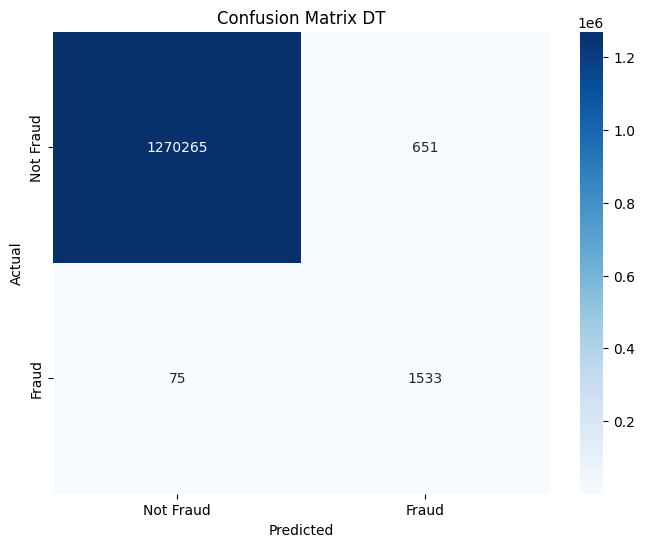

In [56]:
dt_pred = dt_classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test, dt_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix DT')
plt.show()

#  Major decrease in performance after feature engineering ... assumioing the MLP Will be a lot stronger in this scenario

In [57]:
nn_classifier = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
nn_classifier.fit(X_train_resampled, y_train_resampled)

/Users/abdulrahmanamer/opt/anaconda3/envs/Fraud/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)

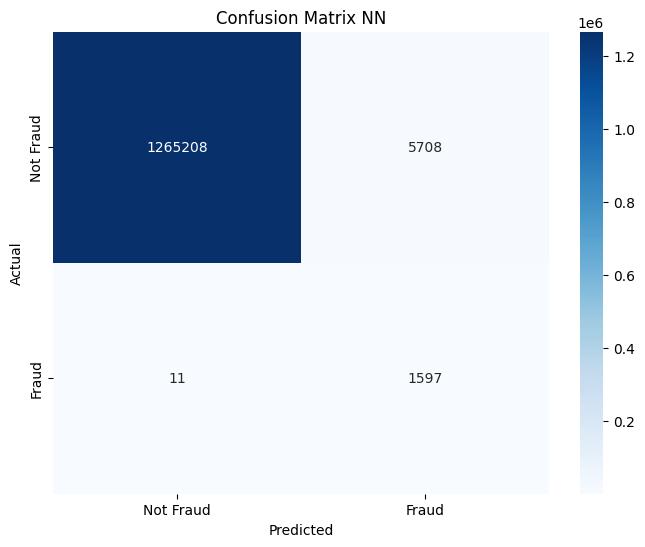

In [58]:
nn_pred = nn_classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test,nn_pred)


# Incredible , no longer need for hybrid model. 

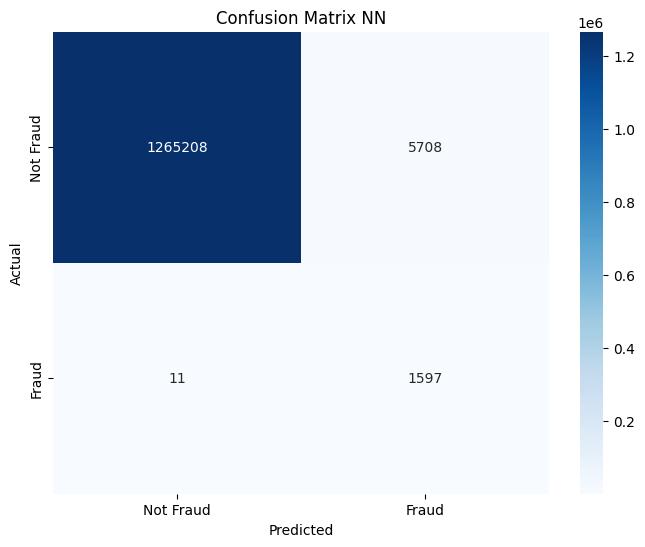

In [60]:

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix NN')
plt.show()

In [59]:
combined_predictions = [int((dt + nn) >= 1) for dt, nn in zip(dt_pred, nn_pred)]

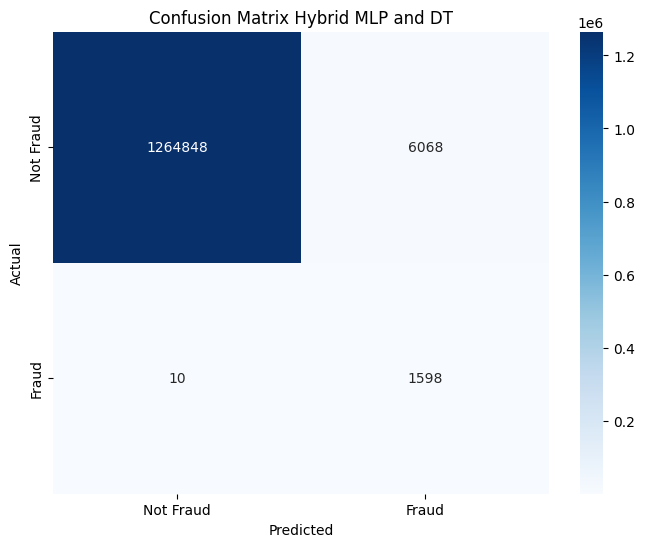

In [61]:
conf_matrix = confusion_matrix(y_test,combined_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Hybrid MLP and DT')
plt.show()

# Saving our models

In [62]:
import pickle

# Assuming nn_classifier is your MLPClassifier instance
with open('mlp_classifier_model.pkl', 'wb') as model_file:
    pickle.dump(nn_classifier, model_file)

In [63]:
import pickle

# Assuming dt_classifier is your DecisionTreeClassifier instance
with open('decision_tree_classifier_model.pkl', 'wb') as model_file:
    pickle.dump(dt_classifier, model_file)